<a href="https://colab.research.google.com/github/rbarman/lfa/blob/master/lesson1/lego_brick_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import random

**Create a databunch from kaggle data**

In [0]:
import json
! pip install -q kaggle
! mkdir ~/.kaggle
with open('kaggle.json', 'w') as outfile:
    json.dump({"username":"rbarman","key":"f3f573fd05ca6c513eac7da4f6b0b383"}, outfile)
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!mkdir data/
!kaggle datasets download joosthazelzet/lego-brick-images --unzip -p data/
!mv data/'LEGO brick images' data/legos
!ls data/legos

 92% 159M/173M [00:02<00:00, 75.1MB/s]
100% 173M/173M [00:02<00:00, 83.6MB/s]
train  valid


In [0]:
# what size to use?
data = ImageDataBunch.from_folder(path='data/legos',bs=64,ds_tfms=get_transforms(),size=75).normalize(imagenet_stats)

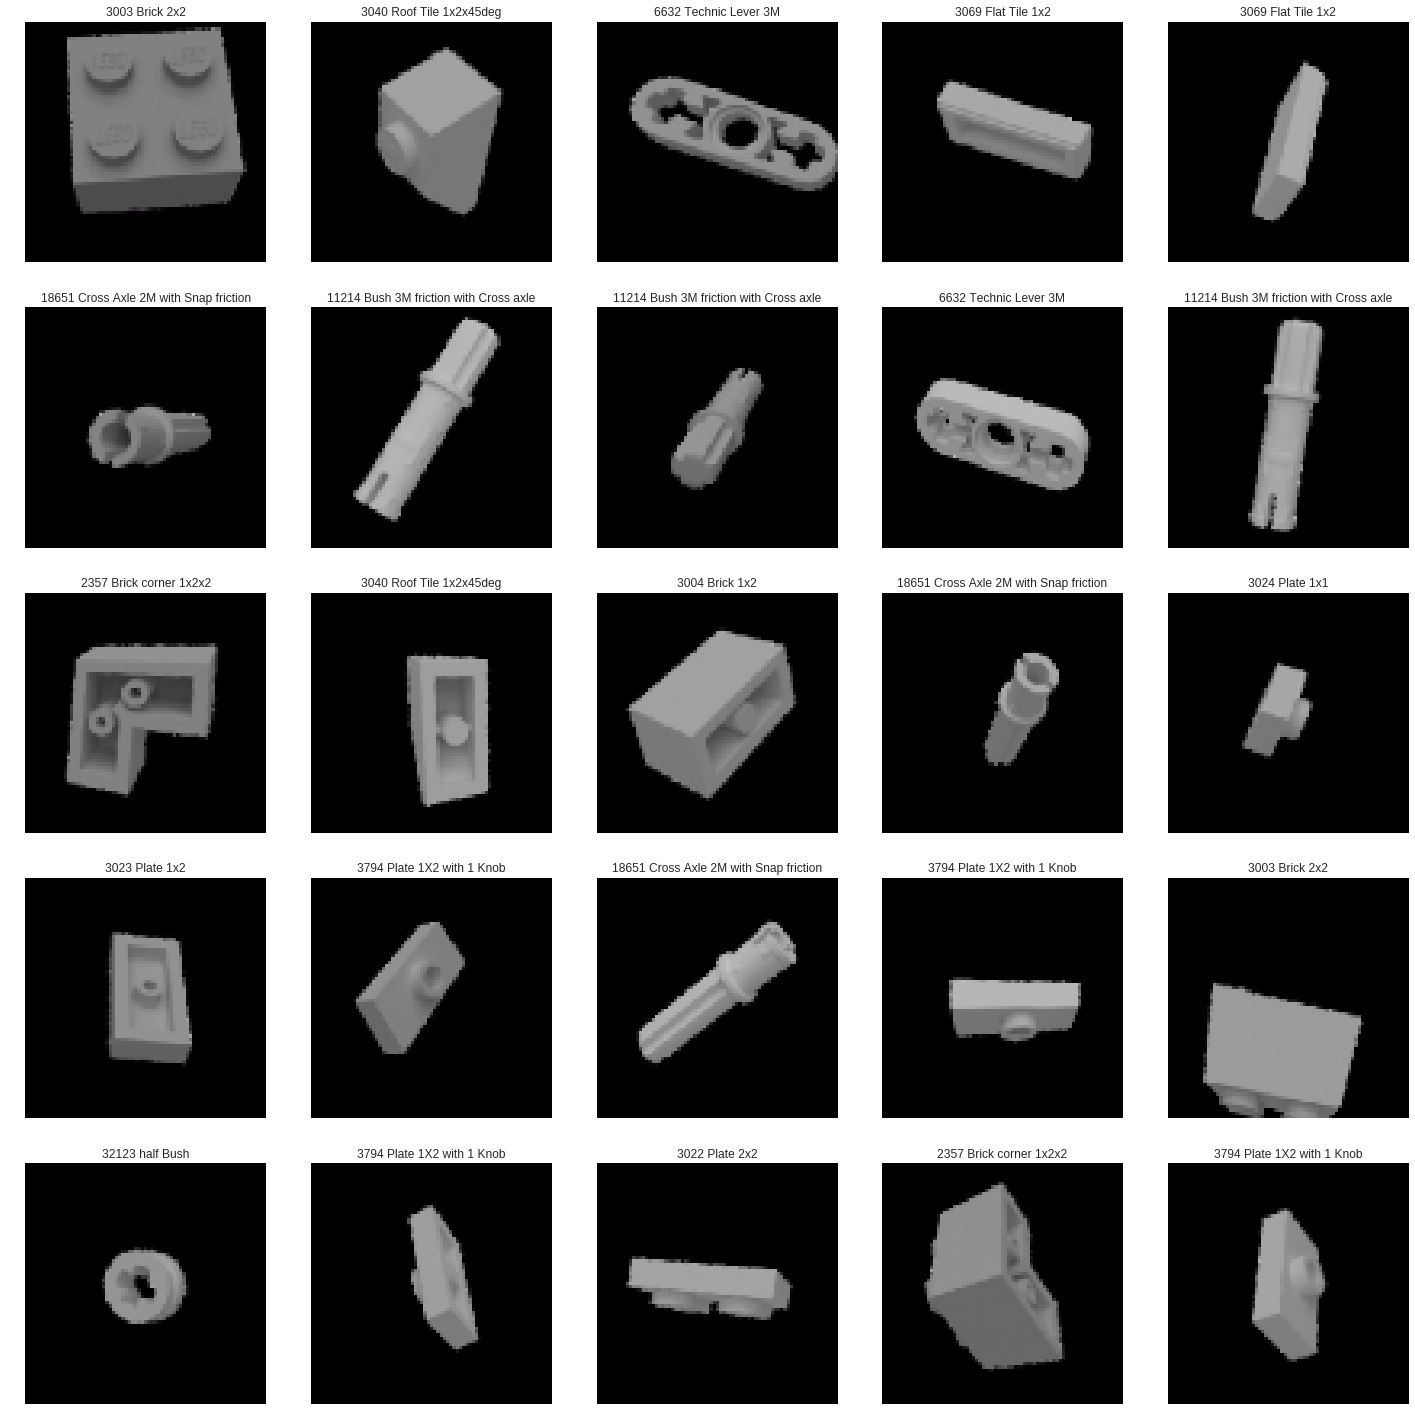

In [0]:
data.show_batch()

**Train Resnet34**

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 48447555.67it/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.604192,0.753649,0.266029
2,0.932953,0.423969,0.157078
3,0.685644,0.313105,0.116006
4,0.580334,0.312257,0.110676


In [0]:
learn.save('stage-1')

**Interpret results from resnet34**

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

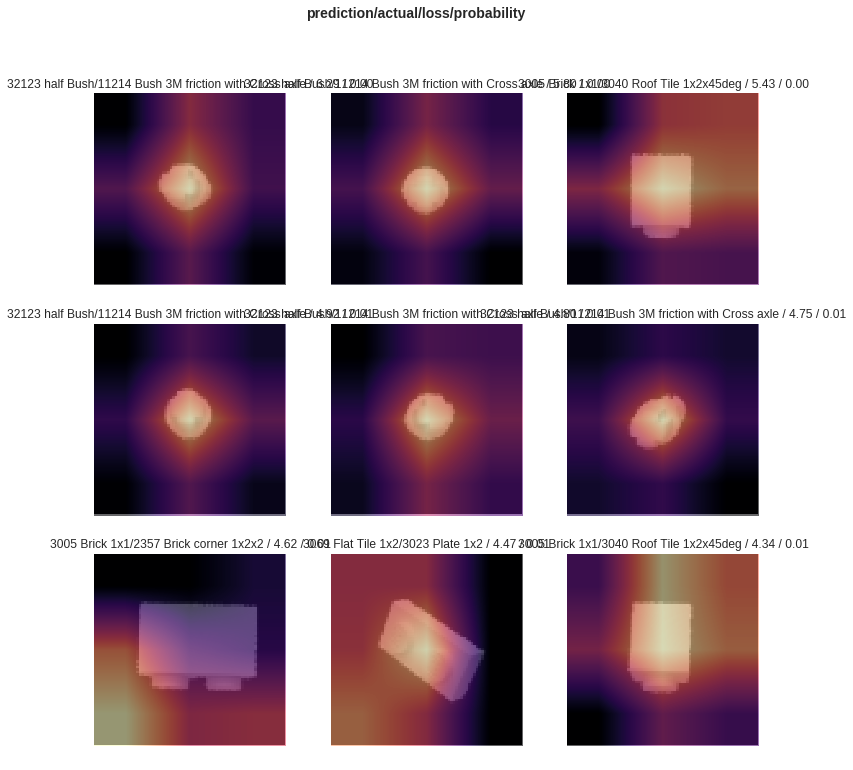

In [0]:
# TODO: modify to get better spacing if a long class
interp.plot_top_losses(9)

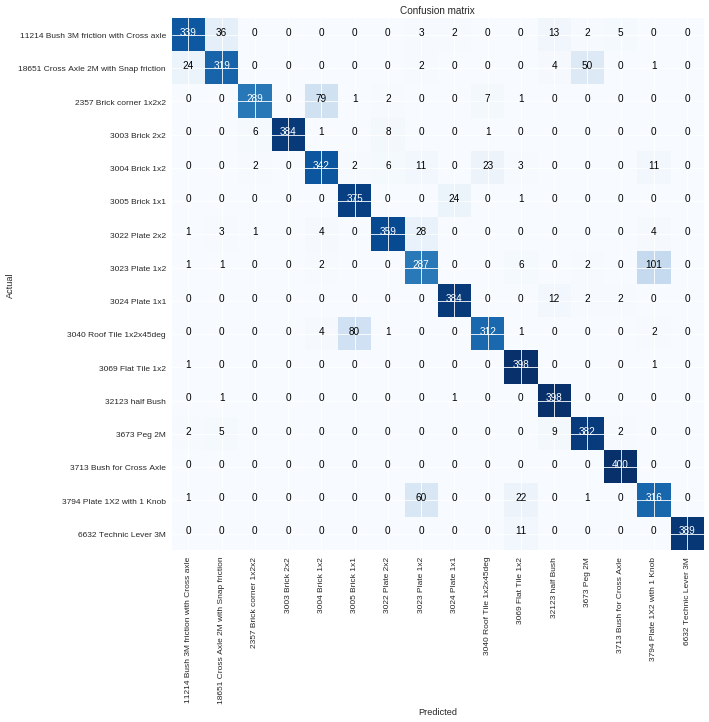

In [0]:
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

Very similar blocks are getting misclassified.


*   Plate 1x2 with Plate 1x2 with 1 know
*   Plate 2x2 with Plate 1x2 
*   etc



In [0]:
interp.most_confused(min_val=2)

[('3023 Plate 1x2', '3794 Plate 1X2 with 1 Knob', 101),
 ('3040 Roof Tile 1x2x45deg', '3005 Brick 1x1', 80),
 ('2357 Brick corner 1x2x2', '3004 Brick 1x2', 79),
 ('3794 Plate 1X2 with 1 Knob', '3023 Plate 1x2', 60),
 ('18651 Cross Axle 2M with Snap friction', '3673 Peg 2M', 50),
 ('11214 Bush 3M friction with Cross axle',
  '18651 Cross Axle 2M with Snap friction',
  36),
 ('3022 Plate 2x2', '3023 Plate 1x2', 28),
 ('18651 Cross Axle 2M with Snap friction',
  '11214 Bush 3M friction with Cross axle',
  24),
 ('3005 Brick 1x1', '3024 Plate 1x1', 24),
 ('3004 Brick 1x2', '3040 Roof Tile 1x2x45deg', 23),
 ('3794 Plate 1X2 with 1 Knob', '3069 Flat Tile 1x2', 22),
 ('11214 Bush 3M friction with Cross axle', '32123 half Bush', 13),
 ('3024 Plate 1x1', '32123 half Bush', 12),
 ('3004 Brick 1x2', '3023 Plate 1x2', 11),
 ('3004 Brick 1x2', '3794 Plate 1X2 with 1 Knob', 11),
 ('6632 Technic Lever 3M', '3069 Flat Tile 1x2', 11),
 ('3673 Peg 2M', '32123 half Bush', 9),
 ('3003 Brick 2x2', '3022 Pl

**Unfreeze - train all layers**

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.539350,0.240317,0.095940


In [0]:
learn.save('stage-2')

**Fine tune even more**

Training all layers actually performs better than using pretrained weights and training final layers. 
* .09594 vs 0.110676 error rate
* unfrozen model was also trained only on one epoch!

We can finetune this model even more by selecting better learning rates

In [0]:
learn.load('stage-1')
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.09E-05


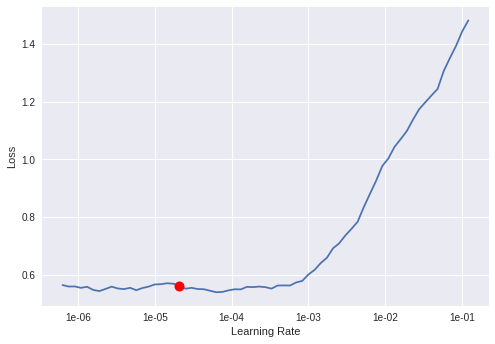

In [0]:
learn.recorder.plot()

Using [general guidelines](https://github.com/hiromis/notes/blob/master/Lesson1.md#how-to-pick-learning-rates-after-unfreezing-12523)
* Initial run used a learning rate of 1e-3 by default. 
* 10 less is 1e-4
* 1e-6 is well before things get worse
* so our new learning rate will be a range from 1e-6 for the early layers to 1e-4 for the later layers


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.498383,0.245946,0.092021
2,0.439951,0.221250,0.080577


Error rate has dropped to .08

**Train Resnet50**

In [0]:
data = ImageDataBunch.from_folder(path='data/legos',bs=32,ds_tfms=get_transforms(),size=75).normalize(imagenet_stats)
learn = create_cnn(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:02, 42442374.23it/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.026971,0.525307,0.192977
2,0.644396,0.272021,0.098448
3,0.472164,0.188001,0.071641
4,0.388636,0.165179,0.059100


In [0]:
learn.save('stage-1')

Pretrained resnet50 is already beating our finetuned resnet34 model. 

**Unfreeze - train all layers**

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.451382,0.175356,0.064587


In [0]:
learn.save('stage-2')

Performance is lower than pretrained model which can make sense. Our learning rate may be too high, especially for the early layers.

**Finetune resnet50 even more**

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


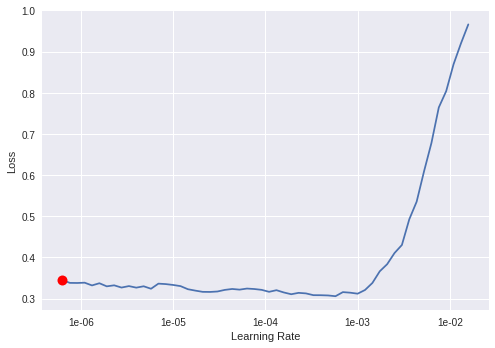

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.276024,0.123946,0.037623
2,0.241339,0.114525,0.041543


In [0]:
learn.save('stage-3')

Fine tuned resnet50 performs much better than the finetuned resnet34

**Interpret resnet50 results**

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

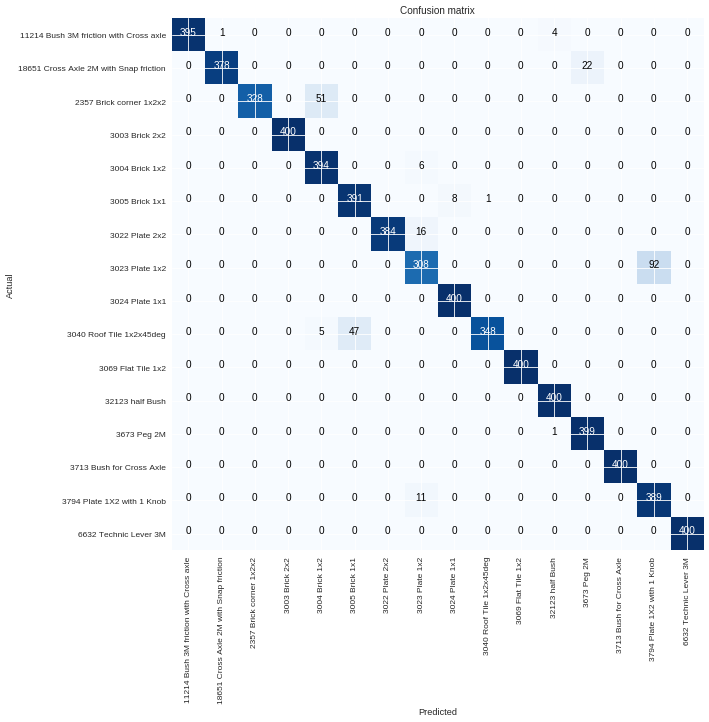

In [0]:
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [0]:
interp.most_confused(min_val=2)

[('3023 Plate 1x2', '3794 Plate 1X2 with 1 Knob', 92),
 ('2357 Brick corner 1x2x2', '3004 Brick 1x2', 51),
 ('3040 Roof Tile 1x2x45deg', '3005 Brick 1x1', 47),
 ('18651 Cross Axle 2M with Snap friction', '3673 Peg 2M', 22),
 ('3022 Plate 2x2', '3023 Plate 1x2', 16),
 ('3794 Plate 1X2 with 1 Knob', '3023 Plate 1x2', 11),
 ('3005 Brick 1x1', '3024 Plate 1x1', 8),
 ('3004 Brick 1x2', '3023 Plate 1x2', 6),
 ('3040 Roof Tile 1x2x45deg', '3004 Brick 1x2', 5),
 ('11214 Bush 3M friction with Cross axle', '32123 half Bush', 4)]

Model improved but still has issues with classifying similar items such as Plate 1X2 and Plate 1X2 with 1 knob

**Visual Differences**

Helper func to examine images from different classes

In [0]:
'''
TODOS for more general use:
  - should accept a list of classes
  - base directory should not be hardcoded

'''
def visualize_classes(class1,class2,n):
  '''visualize images from different classes'''
  
  c1_paths = glob.glob(f'./data/legos/train/{class1}/*.png')
  c2_paths = glob.glob(f'./data/legos/train/{class2}/*.png')
  
  c1_paths = random.sample(c1_paths,n)
  c2_paths = random.sample(c2_paths,n)
  
  _, axarr = plt.subplots(nrows=n,ncols=2,figsize=(15,15))
  [ax.set_axis_off() for ax in axarr.ravel()]
  axarr[0,0].set_title(class1)
  axarr[0,1].set_title(class2)
  
  for count, (c1_path, c2_path) in enumerate(zip(c1_paths, c2_paths)):
    c1_img = mpimg.imread(c1_path)
    c2_img = mpimg.imread(c2_path)

    axarr[count,0].imshow(c1_img)
    axarr[count,1].imshow(c2_img)

The model is most confused when classifying *3794 Plate 1X2 with 1 Knob* vs *3023 Plate 1x2*. We can plot some examples of these blocks and find that the main difference is the number of knobs on the top of the block

The model is getting confused because all of the image data is **rotated**. For example there can be a *3794 Plate 1X2 with 1 Knob* and *3023 Plate 1x2* that are upside down. The model can only see the bottom of these blocks. The bottoms are very similar and the model can not accurately classify. 


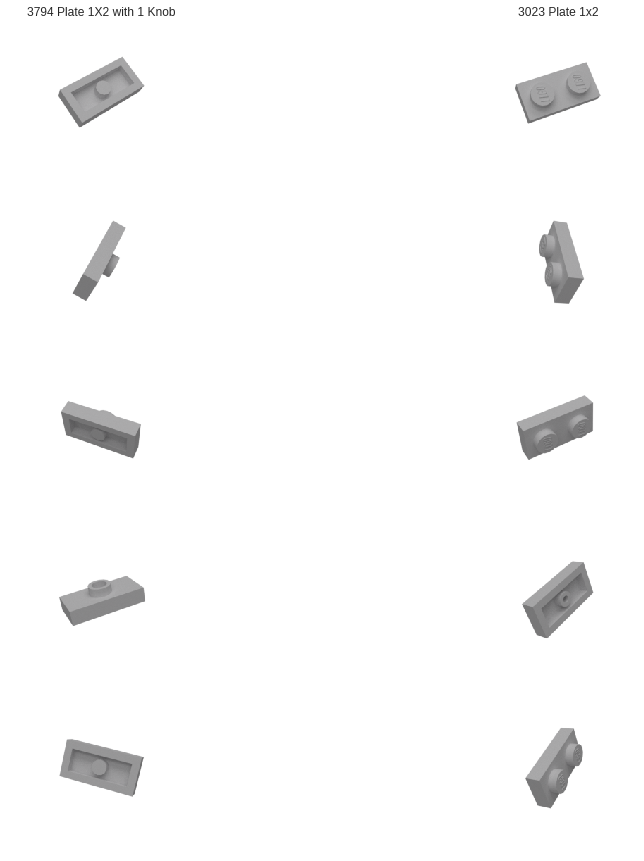

In [122]:
visualize_classes('3794 Plate 1X2 with 1 Knob','3023 Plate 1x2',5)

The problem of rotated data can also explain the model's confusion in classifying *2357 Brick corner 1x2x2* and *3004 Brick 1x2*. The blocks are clearly different - one is a corner block while the other is a 2x1. However if corner block could be angled to only show one side and the model will think it is a simple 1x2 block.

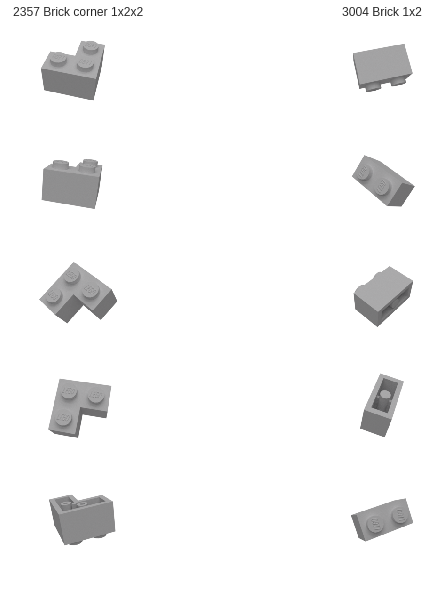

In [118]:
visualize_classes('2357 Brick corner 1x2x2','3004 Brick 1x2',5)

It is not clear how to account for the images being rotated. We *could* remove ambigous examples from our training set and validation set such as when *3794 Plate 1X2 with 1 Knob* and *3023 Plate 1x2* blocks are upside down. However our model will not be prepared for real world data where blocks can be upside down